# Prova 1 (2°/2019)
## DPEE805 - Modelagem e Controle de Conversores
### Prof° Cassiano Rech | Acadêmico: Tiarles da Rocha Moralles Guterres

#### Informações gerais sobre este arquivo:
Este arquivo é um formato impresso de um ambiente em Python chamado Jupyter-notebook. Com o Jupyter-notebook você pode escrever código e documentá-lo simultaneamente, intercalando no que chamamos de células de código, em Python, e células de texto. Apesar de utilizar o navegador e o formato ``.html`` este software possui **nenhuma conexão com a internet**.

#### Um pouco sobre sintaxe:
Python, diferente de MATLAB, não existe um direcionamento específico para cálculos matriciais e modelagem. Porém, utilizando alguns repositórios (também chamados de módulos) podemos realizar quase todos os procedimentos feitos em MATLAB e de forma bem simples. Python e seus pacotes são *open source*.

Os módulos utilizados neste notebook e importados na célula abaixo são:
* **pandas**: Para a leitura de arquivos ``.csv``.
* **matplotlib.pyplot**: Para a geração de figuras a partir de vetores.
* **numpy**: É a biblioteca numérica de Python, onde estão implementadas as estruturas e operações com vetores/matrizes.
* **scipy.signal**: Biblioteca para análise e reposta de sinais em vários domínios.

#### Cenário da Simulação
O script utilizou o último cenário de perturbações (20% de $V_g$) para os resultados existentes aqui.

In [1]:
from pandas import read_csv
from matplotlib.pyplot import figure, plot, subplot, grid, legend, show, savefig
from numpy import array, identity, zeros, dot, ones, arange
from numpy.linalg import inv
from scipy.signal import StateSpace, lsim

sim_name = '20_Vg' # Nome criado para as figuras referente a perturbação de 20% de Vg

###### 

<a id='step_function'></a>

Abaixo a função para simular o bloco de *step* do Simulink é declarada:

In [2]:
def step(t, t_step, y_inital, y_final, nome):
    ret = ones(t.size)
    
    yt_initial = t < t_step
    ret[yt_initial] = y_inital
    
    yt_final = t >= t_step
    ret[yt_final] = y_final
    
    figure(figsize=(5,1))
    plot(t, ret, label=nome)
    legend()
    grid()
    show()

    return ret

Na célula abaixo, o arquivo com as ondas do PSIM é importado, algumas configurações são realizadas e é possível ver as primeiras e últimas amostras do arquivo:

In [3]:
df = read_csv('PSIM_waves.csv') # Aqui ocorre a importação do arquivo .csv

# E aqui a coluna que mostra o tempo instantâneo de cada amostra é setado como o indíce desta tabela
df = df.set_index('Time')

df

,I,V,Vref
Time,,,
0.000001,0.03500,-2.910640e-08,18.75
0.000002,0.07000,-5.812680e-08,18.75
0.000003,0.10500,-8.708270e-08,18.75
0.000004,0.14000,-1.159530e-07,18.75
0.000005,0.17500,-1.447380e-07,18.75
...,...,...,...
0.049996,1.73190,2.258820e+01,18.75
0.049997,1.71382,2.261310e+01,18.75
0.049998,1.69572,2.263700e+01,18.75


Abaixo cada uma das colunas de interesse são inseridas em variáveis diferentes para, mais tarde, compararmos com o modelo matemático calculado em espaço de estados:

In [4]:
iL = df['I']
vC = df['V']

E as correntes nos indutores e as tensões dos capacitores do **modelo físico** podem ser visualizados.

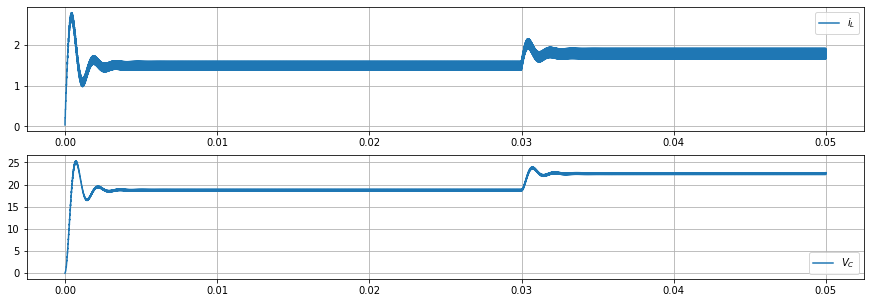

In [5]:
figure(figsize=(15, 5))
subplot(211)
plot(iL, label='$i_{L}$')
legend()
grid()
subplot(212)
plot(vC, label='$V_{C}$')
legend()
grid()
savefig('1_ondas_PSIM_'+sim_name+'.png')
show()

#### Modelagem no espaço de estados

O tempo de simulação (``t_final``), a taxa de amostragem (``t_step``), os valores dos componentes (``L1``, ``L2``, ``Cap1``, ``Cap2`` e ``R``), a fonte de entrada (``Vin``), a razão cíclica (``D``), a pertubação da razão cíclica ($\hat{d}$ = ``d_f``) e a pertubação na fonte de entrada ($\hat{u}$ = ``v_f``) foram configurados abaixo:

In [6]:
Lm = 10e-3
Cf = 150e-6
R = 2.25

Vg = 350
D = 0.3

t_step = 1e-6
t_final = .05

d_f = 0
v_f = 70

E, como no arquivo ``aula_buckboost.m`` as matrizes para a modelagem são montadas:

In [7]:
K = array([[Lm,  0],
            [0, Cf]])

**Primeira** Etapa do conversor (**$S$ on, $D_f$ off**)

In [8]:
A1 = array([[0,  0],
            [0,  -1/R]])
B1 = array([1, 0])
C1 = identity(2)
E1 = zeros(2)

**Segunda** Etapa do conversor (****$S$ off, $D_f$ on****)

In [9]:
A2 = array([[0,   -8],
            [8, -1/R]])
B2 = array([0, 0])
C2 = identity(2)
E2 = zeros(2)

As matrizes médias:

In [10]:
A = D*A1 + (1-D)*A2;
B = D*B1 + (1-D)*B2;
C = D*C1 + (1-D)*C2;
E = D*E1 + (1-D)*E2;

Os valores em regime permanente. (Para a computação correta do produto escalar é utilizada a função ``dot``):

In [11]:
U = Vg
X = dot(dot(-inv(A), B), U)
Y = dot((dot(dot(-C, inv(A)), B)+E), U)

Matrizes padrão para representação do modelo CA em espaço de estados

In [12]:
Ap = dot(inv(K),A)
print(Ap)

[[    0.          -560.        ]
 [37333.33333333 -2962.96296296]]


Devido a sintaxe de Python as matrizes ``Bp`` e ``Ep``, que contém as componentes que multiplicam $\hat{d}$ e $\hat{u}$, necessitam ser transpostas (função ``.transpose()``):

In [13]:
Bp = array([dot(inv(K), B), 
            dot(inv(K), (dot((A1-A2),X) + dot((B1-B2), U)))]).transpose()
print(Bp)

[[ 3.00000000e+01  5.00000000e+04]
 [ 0.00000000e+00 -7.93650794e+04]]


In [14]:
Cp = C
print(Cp)

[[1. 0.]
 [0. 1.]]


In [15]:
Ep = array([E, dot((C1-C2),X) + dot((E1-E2),U)]).transpose()
print(Ep)

[[0. 0.]
 [0. 0.]]


Com as matrizes ``Ap``, ``Bp``, ``Cp``, ``Ep`` calculadas o modelo de espaço de estado é montado (a partir daqui o notebook assume o que o ``buckboost.mdl`` no Simulink faz)

In [16]:
ss_buckboost = StateSpace(Ap, Bp, Cp, Ep)

Um sinal de tempo (``t_in``) e os steps de entrada (``u`` e ``d``) são gerados utilizando a função [step](#step_function) criada.

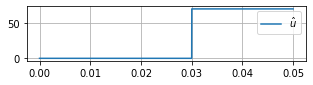

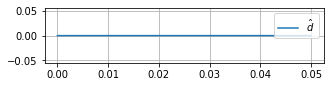

In [17]:
t_in = arange(0, t_final, t_step)

u = step(t_in, .03, 0, v_f, '$\hat{u}$')
d = step(t_in, .03, 0, d_f, '$\hat{d}$')

up = array([u, d]).transpose()

Nesse momento, com as entradas definidas e o modelo pronto podemos evolui-lo no espaço de estados utilizando a função ``lsim``:

In [18]:
t, y1, _ = lsim(ss_buckboost, up, T=t_in)

E a resposta do modelo pertubado é somado com a saída ``Y``:

In [19]:
iL_ss = y1[:,0] + Y[0]
vC_ss = y1[:,1] + Y[1]

A figura abaixo mostra o modelo obtido para as medidas de interesse:

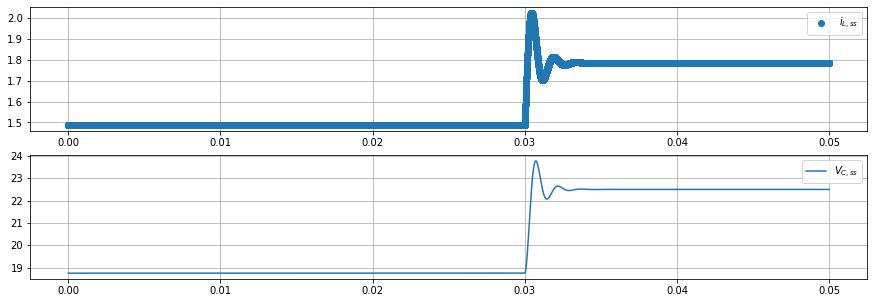

In [20]:
figure(figsize=(15, 5))

subplot(211)
plot(t, iL_ss, 'o', label='$i_{L, ss}$')
legend()
grid()

subplot(212)
plot(t, vC_ss, label='$V_{C, ss}$')
legend()
grid()
savefig('2_ondas_Matematico_'+sim_name+'.png')
show()

E por fim, o modelo de espaço de estados é comparado com o modelo físico:

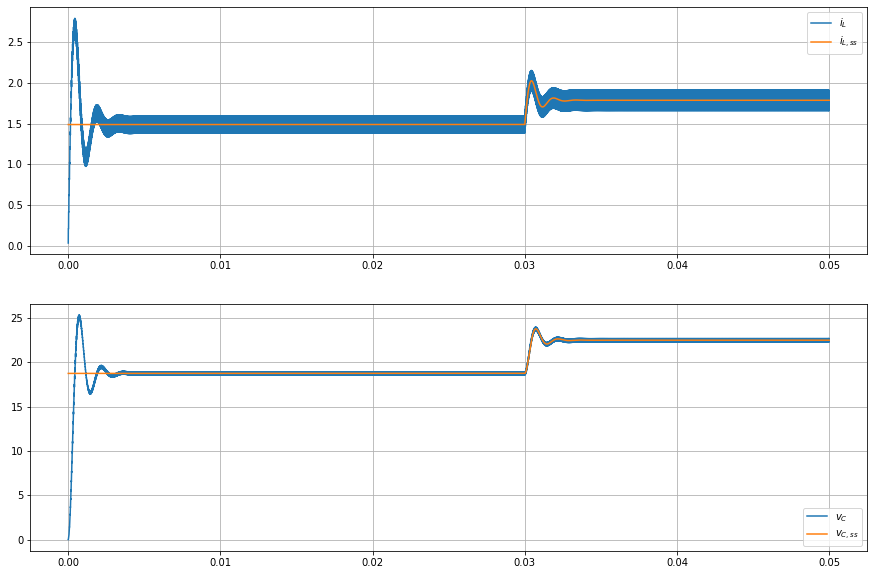

In [21]:
figure(figsize=(15, 10))

subplot(211)
plot(df.index, iL, label='$i_{L}$')
plot(t, iL_ss, label='$i_{L, ss}$')
legend()
grid()

subplot(212)
plot(df.index, vC, label='$v_{C}$')
plot(t, vC_ss, label='$v_{C, ss}$')
legend()
grid()

savefig('3_comparacao_modelos_'+sim_name+'.png')

show()

## Geração da Função de Transferência

Devido algumas diferenças toleráveis na computação de valores muito grandes os arrays com numeradores e o denominadores gerados foram **arredondados para 6 casas decimais**. Isto deixa mais clara a representação da função de transferência.

In [22]:
from scipy.signal import ss2tf
from control import tf
from numpy import around

In [23]:
(num, den) = ss2tf(Ap,Bp,Cp,Ep,0)

n_of_decimals = 6
num = around(num, n_of_decimals)
den = around(den, n_of_decimals)

Gi_vg = tf(num[0], den)
Gv_vg = tf(num[1], den)

In [24]:
print(Gi_vg)
print(Gv_vg)


    30 s + 8.889e+04
------------------------
s^2 + 2963 s + 2.091e+07


        1.12e+06
------------------------
s^2 + 2963 s + 2.091e+07



In [25]:
(num, den) = ss2tf(Ap,Bp,Cp,Ep,1)

num = around(num, n_of_decimals)
den = around(den, n_of_decimals)

Gi_vg = tf(num[0], den)
Gv_vg = tf(num[1], den)

In [26]:
print(Gi_vg)
print(Gv_vg)


  5e+04 s + 1.926e+08
------------------------
s^2 + 2963 s + 2.091e+07


-7.937e+04 s + 1.867e+09
------------------------
s^2 + 2963 s + 2.091e+07



## Rascunho:

Para validar a equação de ganho:

In [27]:
# D = .8
# Vg = 100

# M = D / (8 - 8*D)
# M*Vg

In [28]:
Vg * 20/100

70.0